In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configure scanpy settings
sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Clustering and Gene Set Enrichment Analysis

## Overview

This notebook performs clustering analysis and functional enrichment on the quality-controlled macrophage dataset. The analysis includes:

1. **Multi-Resolution Clustering**: Apply Leiden clustering at different resolutions to identify optimal granularity
2. **Cluster Validation**: Evaluate clustering quality through marker gene analysis
3. **Marker Gene Discovery**: Identify top marker genes for each cluster using differential expression
4. **Functional Enrichment**: Perform gene set enrichment analysis using G:Profiler to understand cluster biology

## Analysis Goals

- Identify distinct macrophage subpopulations and states
- Characterize clusters through marker genes and functional pathways
- Understand biological differences between alveolar and interstitial macrophages
- Investigate infection-induced transcriptional changes within cell types

## Input Data

Quality-controlled dataset from notebook 2 containing purified alveolar and interstitial macrophages from control and Klebsiella pneumoniae-infected mice.

## Data Loading

### Load Quality-Controlled Dataset

In [2]:
# Load the quality-controlled dataset
adata = sc.read_h5ad('QCed_GSE184290.h5ad')

print(f"Loaded dataset: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"Experimental conditions: {sorted(adata.obs['condition'].unique())}")
print(f"Existing clusters: {adata.obs['leiden'].nunique()} clusters")

# Import additional packages for enrichment analysis
import celltypist as ct
import decoupler as dc

print("Additional packages loaded: CellTypist, Decoupler")

Loaded dataset: 2,399 cells × 13,646 genes
Experimental conditions: ['AM_Control', 'AM_KP+', 'AM_KP-', 'IM_Control', 'IM_KP+', 'IM_KP-']
Existing clusters: 11 clusters
Additional packages loaded: CellTypist, Decoupler


## Multi-Resolution Clustering Analysis

### Leiden Clustering at Multiple Resolutions

To identify the optimal clustering granularity, we'll apply Leiden clustering at three different resolutions and compare the results.

Clustering completed at multiple resolutions:
Resolution 0.02: 2 clusters
Resolution 0.5: 10 clusters
Resolution 2.0: 29 clusters


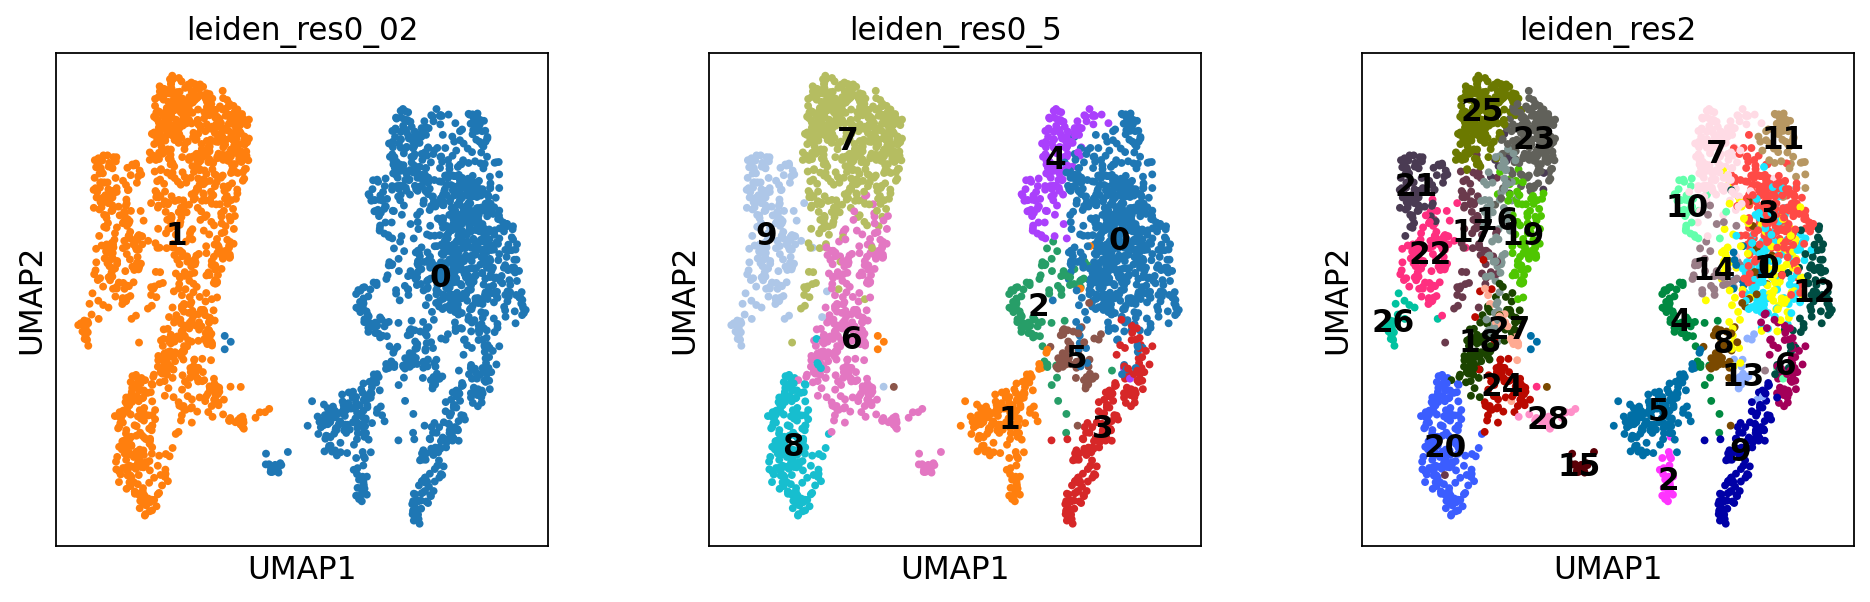

In [3]:
# Apply Leiden clustering at multiple resolutions
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res2", resolution=2)

print("Clustering completed at multiple resolutions:")
print(f"Resolution 0.02: {adata.obs['leiden_res0_02'].nunique()} clusters")
print(f"Resolution 0.5: {adata.obs['leiden_res0_5'].nunique()} clusters")
print(f"Resolution 2.0: {adata.obs['leiden_res2'].nunique()} clusters")

# Visualize clustering results
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)

### Resolution Selection

**Clustering Resolution Analysis:**

- **Resolution 0.02**: Likely under-clustered, potentially grouping distinct alveolar and interstitial macrophage populations together
- **Resolution 0.5**: Appears optimal, providing a balanced separation that likely distinguishes biologically meaningful subpopulations
- **Resolution 2.0**: Over-clustered, fragmenting coherent cell populations into unnecessarily small clusters

The middle resolution (0.5) provides the most biologically interpretable clustering, balancing granularity with biological coherence. This resolution likely captures genuine macrophage subpopulations without excessive fragmentation.

## Cluster Characterization

### Marker Gene Discovery

Identify marker genes that distinguish each cluster to validate clustering quality and understand cluster identity.

In [4]:
# Perform differential expression analysis to find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added='ranked_genes')

# Extract top marker genes for each cluster
top_n_genes_to_plot = 5
marker_genes_dict = {}

cluster_names = adata.obs['leiden'].cat.categories
for cluster in cluster_names:
    genes_for_this_cluster = adata.uns['ranked_genes']['names'][cluster].tolist()[:top_n_genes_to_plot]
    genes_for_this_cluster = [gene for gene in genes_for_this_cluster if pd.notna(gene)]
    
    if genes_for_this_cluster:
        marker_genes_dict[cluster] = genes_for_this_cluster
    else:
        print(f"Warning: No marker genes found for cluster {cluster}")

print(f"Extracted top {top_n_genes_to_plot} marker genes for {len(cluster_names)} clusters")
print(f"Clusters with markers: {list(marker_genes_dict.keys())}")

# Display cluster sizes
cluster_sizes = adata.obs['leiden'].value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster, count in cluster_sizes.items():
    print(f"  Cluster {cluster}: {count:,} cells")

Extracted top 5 marker genes for 11 clusters
Clusters with markers: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

Cluster sizes:
  Cluster 0: 555 cells
  Cluster 1: 155 cells
  Cluster 2: 178 cells
  Cluster 3: 180 cells
  Cluster 4: 53 cells
  Cluster 5: 109 cells
  Cluster 6: 16 cells
  Cluster 7: 288 cells
  Cluster 8: 482 cells
  Cluster 9: 185 cells
  Cluster 10: 198 cells


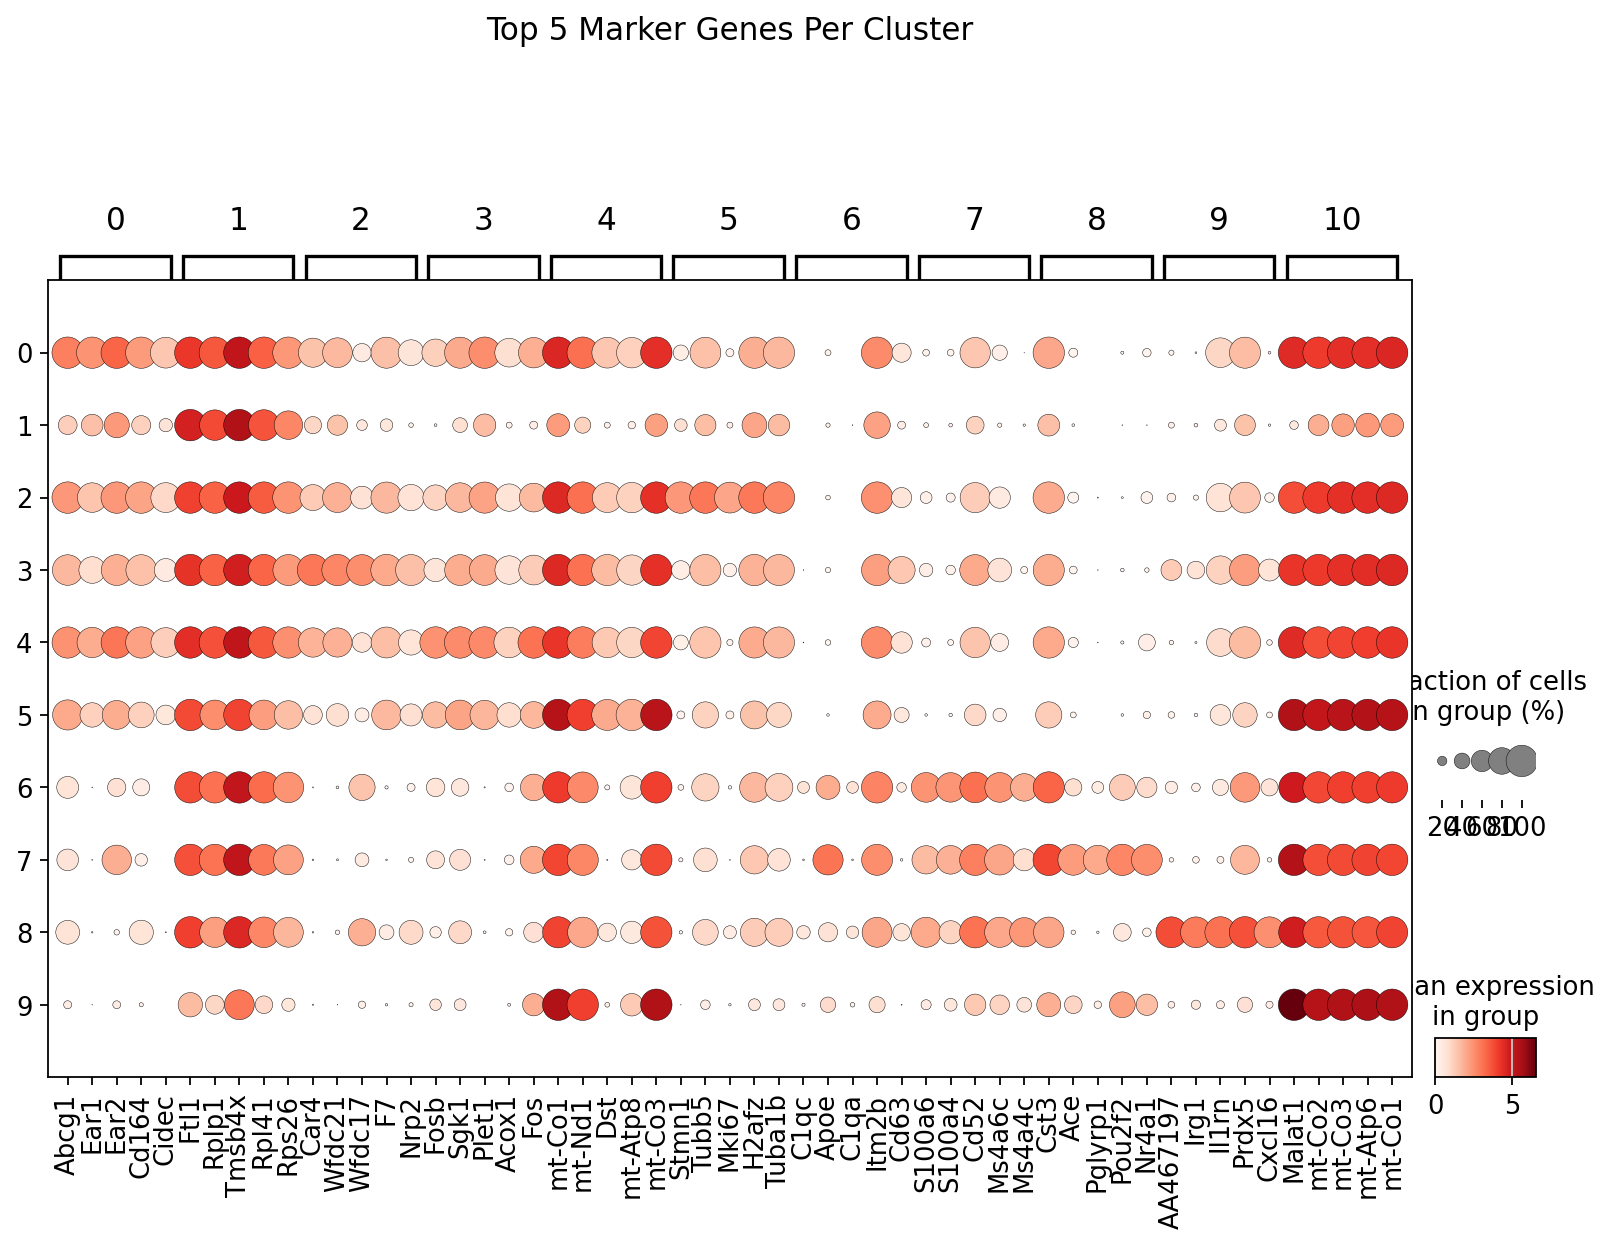

Dot plot shows marker gene expression across clusters
High expression (red) and high percentage (large dots) indicate cluster-specific markers


In [5]:
# Visualize marker genes as a dot plot
fig, ax = plt.subplots(figsize=(10, 8))

sc.pl.dotplot(
    adata,
    var_names=marker_genes_dict,
    groupby='leiden_res0_5',
    ax=ax,
    title=f'Top {top_n_genes_to_plot} Marker Genes Per Cluster',
    show=False
)

plt.tight_layout()
plt.show()

print("Dot plot shows marker gene expression across clusters")
print("High expression (red) and high percentage (large dots) indicate cluster-specific markers")

## Functional Enrichment Analysis

### Gene Set Enrichment with G:Profiler

Functional enrichment analysis helps interpret cluster identity by identifying biological pathways and processes enriched in cluster marker genes.

**Gene Set Sources:**
- **Marker genes per cluster**: Top differentially expressed genes defining each cluster
- **Enrichment databases**: Gene Ontology (Biological Process), KEGG pathways, Reactome pathways

This analysis will reveal the functional specialization of different macrophage subpopulations and infection-induced states.

In [6]:
# Initialize G:Profiler for functional enrichment analysis
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)

# Configure analysis parameters
organism_id = 'mmusculus'  # Mouse organism
background_genes = adata.var_names.tolist()  # All genes in dataset as background

print(f"G:Profiler configured for {organism_id}")
print(f"Background gene set: {len(background_genes):,} genes")

G:Profiler configured for mmusculus
Background gene set: 13,646 genes


In [7]:
# Prepare gene lists for enrichment analysis
# Extract top 100 marker genes per cluster for comprehensive analysis
all_cluster_marker_genes = {}

for cluster in adata.obs['leiden'].cat.categories:
    genes_for_cluster = adata.uns['ranked_genes']['names'][cluster].tolist()[:100]
    genes_for_cluster = [gene for gene in genes_for_cluster if pd.notna(gene)]
    all_cluster_marker_genes[f'cluster_{cluster}'] = genes_for_cluster

print(f"Prepared gene lists for {len(all_cluster_marker_genes)} clusters")
for cluster_name, genes in all_cluster_marker_genes.items():
    print(f"  {cluster_name}: {len(genes)} marker genes")

Prepared gene lists for 11 clusters
  cluster_0: 100 marker genes
  cluster_1: 100 marker genes
  cluster_2: 100 marker genes
  cluster_3: 100 marker genes
  cluster_4: 100 marker genes
  cluster_5: 100 marker genes
  cluster_6: 100 marker genes
  cluster_7: 100 marker genes
  cluster_8: 100 marker genes
  cluster_9: 100 marker genes
  cluster_10: 100 marker genes


In [8]:
# Perform functional enrichment analysis for each cluster
all_enrichment_results_df = []

for cluster_name, genes_list in all_cluster_marker_genes.items():
    print(f"Running enrichment for {cluster_name} ({len(genes_list)} genes)")
    
    if not genes_list:
        print(f"  Skipping {cluster_name} - no genes")
        continue

    try:
        results = gp.profile(
            organism=organism_id,
            query=genes_list,
            sources=['GO:BP', 'KEGG', 'REAC'],  # Biological processes, KEGG, Reactome
            background=background_genes,
            user_threshold=0.05
        )

        if not results.empty:
            results['cluster'] = cluster_name
            all_enrichment_results_df.append(results)
            print(f"  Found {len(results)} significant terms")
        else:
            print(f"  No significant terms found (p < 0.05)")

    except Exception as e:
        print(f"  Error in enrichment analysis: {e}")

# Combine and save results
if all_enrichment_results_df:
    final_enrichment_df = pd.concat(all_enrichment_results_df, ignore_index=True)
    
    print(f"\nEnrichment Analysis Summary:")
    print(f"  Total significant terms: {len(final_enrichment_df):,}")
    print(f"  Clusters with enrichment: {final_enrichment_df['cluster'].nunique()}")
    
    # Save results
    output_file = "gprofiler_all_cluster_enrichment.csv"
    final_enrichment_df.to_csv(output_file, index=False)
    print(f"  Results saved to: {output_file}")
    
    # Show top enriched terms
    print(f"\nTop enriched terms (first 5):")
    print(final_enrichment_df[['cluster', 'name', 'p_value', 'source']].head())
    
else:
    print("No enrichment results generated for any cluster")

Running enrichment for cluster_0 (100 genes)
  Found 12 significant terms
Running enrichment for cluster_1 (100 genes)
  Found 44 significant terms
Running enrichment for cluster_2 (100 genes)
  Found 43 significant terms
Running enrichment for cluster_3 (100 genes)
  Found 7 significant terms
Running enrichment for cluster_4 (100 genes)
  Found 56 significant terms
Running enrichment for cluster_5 (100 genes)
  Found 180 significant terms
Running enrichment for cluster_6 (100 genes)
  Found 97 significant terms
Running enrichment for cluster_7 (100 genes)
  Found 72 significant terms
Running enrichment for cluster_8 (100 genes)
  Found 131 significant terms
Running enrichment for cluster_9 (100 genes)
  Found 168 significant terms
Running enrichment for cluster_10 (100 genes)
  Found 65 significant terms

Enrichment Analysis Summary:
  Total significant terms: 875
  Clusters with enrichment: 11
  Results saved to: gprofiler_all_cluster_enrichment.csv

Top enriched terms (first 5):
   

## Data Export

### Save Clustered Dataset

Export the annotated dataset with clustering results for downstream analysis.

In [10]:
# Save the clustered dataset
output_file = 'clustered_GSE184290.h5ad'
adata.write(output_file)

print("Clustering and Enrichment Analysis Summary:")
print(f"  Final dataset: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"  Optimal resolution: 0.5 ({adata.obs['leiden_res0_5'].nunique()} clusters)")
print(f"  Marker genes identified for each cluster")
print(f"  Functional enrichment completed")

print(f"\nDataset saved to: {output_file}")
print(f"Enrichment results saved to: gprofiler_all_cluster_enrichment.csv")

print(f"\nCluster composition:")
for cluster in sorted(adata.obs['leiden_res0_5'].cat.categories):
    count = (adata.obs['leiden_res0_5'] == cluster).sum()
    print(f"  Cluster {cluster}: {count:,} cells")

print(f"\nAnalysis complete - ready for differential expression and pathway analysis")

Clustering and Enrichment Analysis Summary:
  Final dataset: 2,399 cells × 13,646 genes
  Optimal resolution: 0.5 (10 clusters)
  Marker genes identified for each cluster
  Functional enrichment completed

Dataset saved to: clustered_GSE184290.h5ad
Enrichment results saved to: gprofiler_all_cluster_enrichment.csv

Cluster composition:
  Cluster 0: 619 cells
  Cluster 1: 156 cells
  Cluster 2: 89 cells
  Cluster 3: 161 cells
  Cluster 4: 149 cells
  Cluster 5: 56 cells
  Cluster 6: 308 cells
  Cluster 7: 478 cells
  Cluster 8: 174 cells
  Cluster 9: 209 cells

Analysis complete - ready for differential expression and pathway analysis
